<a href="https://colab.research.google.com/github/randaama/DS4002_Group2_Project3/blob/main/loadimage_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# If your dataset is in your Google Drive and you are using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.auto import tqdm

In [3]:
# Check for GPU
#device = "cuda" if torch.cuda.is_available() else "cpu"

# Check for GPU in mac
device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'cpu'

In [4]:
def preprocess_image(img):
    # Resize the image
    img_resized = img.resize((128, 128))  # Resize to 128x128 pixels

    # Convert to RGB (if it's not already in RGB)
    img_rgb = cv2.cvtColor(np.array(img_resized), cv2.COLOR_BGR2RGB)

    # Normalize the image to [0, 1] by dividing by 255.0
    img_normalized = img_rgb / 255.0

    return img_normalized

In [5]:
def create_image_dataframe(base_dir):
    # List to hold the rows of the dataframe
    data = []

    # Loop over the 'train' and 'test' directories
    for split in ['train', 'test']:
        split_dir = os.path.join(base_dir, split)

        # Check if the split directory exists
        if not os.path.isdir(split_dir):
            print(f"Directory not found: {split_dir}")
            continue

        # Iterate over each impairment type directory within train/test
        for impairment_type in ['Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment','No Impairment']:
            impairment_dir = os.path.join(split_dir, impairment_type)

            for img_name in os.listdir(impairment_dir):
                if img_name.lower().endswith('.jpg'):
                    # Full image path
                    img_path = os.path.join(impairment_dir, img_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img,(128,128))
                    b, g, r = cv2.split(img)
                    img = cv2.merge([r,g,b])
                    # Append a new row with the image object
                    data.append([impairment_type, img_name, img_path, img])

# Convert the list of data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['Impairment_Type', 'Image_Name', 'Image_Path', 'Image_Data'])
    return df

# Define your base directory where 'train' and 'test' folders are located
base_dir = '/content/drive/MyDrive/alzheimer detection'

# Generate the dataframe
df = create_image_dataframe(base_dir)

# Display the first few rows
print(df.head())

       Impairment_Type                                         Image_Name  \
0  Moderate Impairment  ModerateImpairment-1756-_jpg.rf.206c98c4b1d0a1...   
1  Moderate Impairment  ModerateImpairment-2500-_jpg.rf.5d5865571db929...   
2  Moderate Impairment  ModerateImpairment-809-_jpg.rf.42d22d7ba796597...   
3  Moderate Impairment  ModerateImpairment-1934-_jpg.rf.3df0246ce3e9fd...   
4  Moderate Impairment  ModerateImpairment-720-_jpg.rf.cf03ed557e3da3c...   

                                          Image_Path  \
0  /content/drive/MyDrive/alzheimer detection/tra...   
1  /content/drive/MyDrive/alzheimer detection/tra...   
2  /content/drive/MyDrive/alzheimer detection/tra...   
3  /content/drive/MyDrive/alzheimer detection/tra...   
4  /content/drive/MyDrive/alzheimer detection/tra...   

                                          Image_Data  
0  [[[6, 6, 6], [14, 14, 14], [18, 18, 18], [4, 4...  
1  [[[8, 8, 8], [7, 7, 7], [5, 5, 5], [2, 2, 2], ...  
2  [[[4, 4, 4], [3, 3, 3], [0, 0, 0

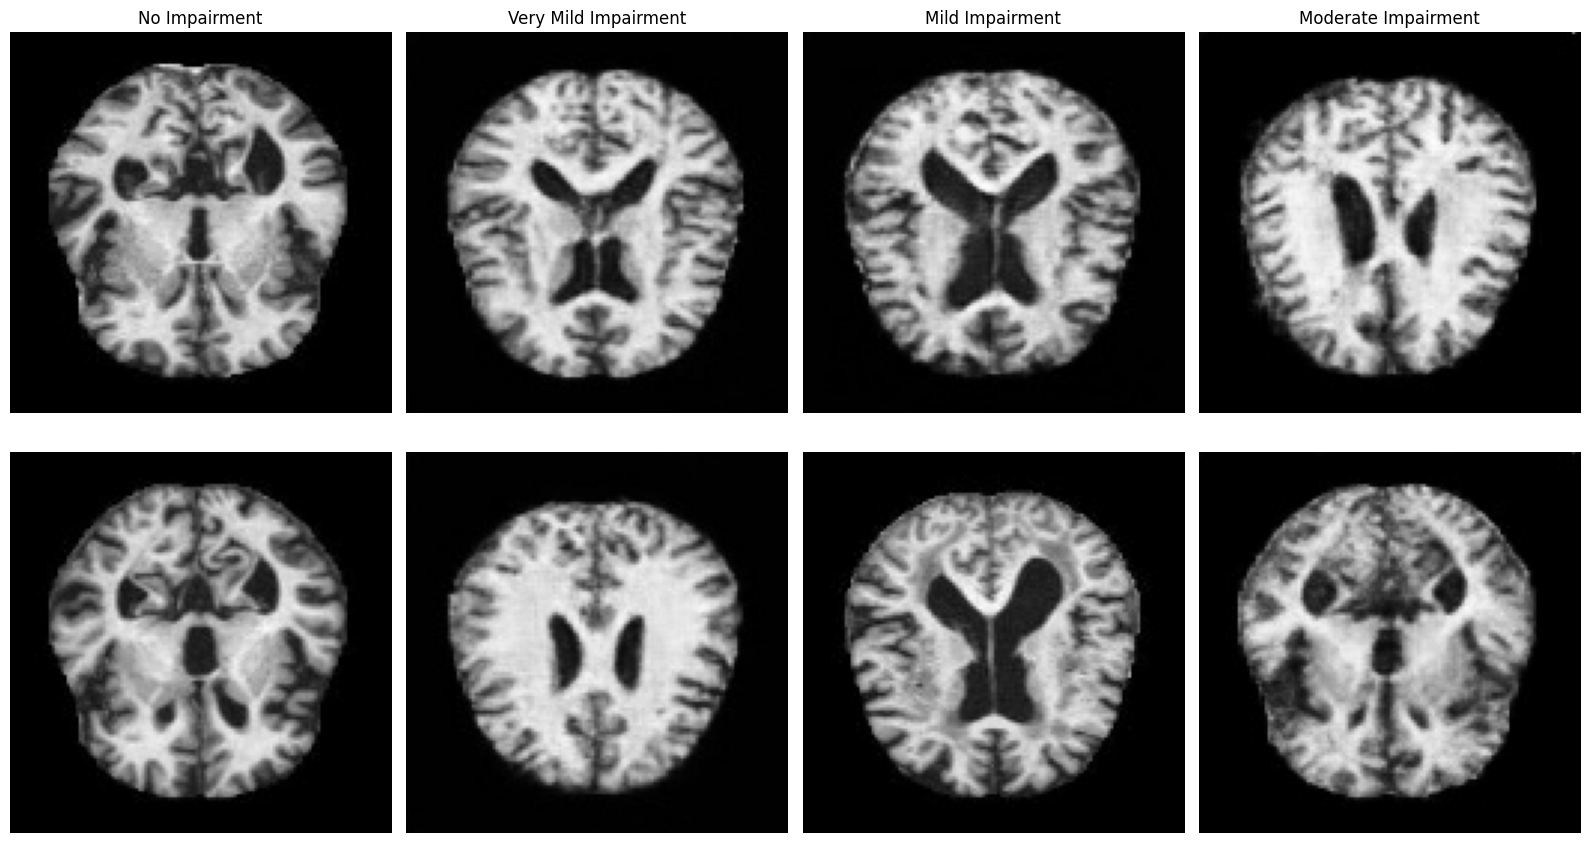

In [6]:
def plot_by_impairment_type(df, impairment_types=['No Impairment', 'Very Mild Impairment', 'Mild Impairment', 'Moderate Impairment'], num=10):
    # Create a figure with 2 rows and len(impairment_types) columns
    fig, axes = plt.subplots(2, len(impairment_types), figsize=(16, 9))

    # Loop through each impairment type and select random images to display
    for i, impairment_type in enumerate(impairment_types):
        # Filter the DataFrame for the current impairment type
        impairment_data = df[df['Impairment_Type'] == impairment_type]

        # Randomly select 'num' images
        sampled_imgs = impairment_data.sample(n=num, random_state=42)

        # Plot the selected images for the current impairment type
        for j in range(num):
            img = sampled_imgs.iloc[j]['Image_Data']
            row = j // (num // 2)  # Determine row (0 or 1)
            col = j % (num // 2)  # Determine column position (0 to len(impairment_types) - 1)
            ax = axes[row, i]  # Select the appropriate subplot
            ax.imshow(img)
            ax.axis('off')

        # Set the title for the subplot
        axes[0, i].set_title(impairment_type)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_by_impairment_type(df, impairment_types=['No Impairment', 'Very Mild Impairment', 'Mild Impairment', 'Moderate Impairment'], num=10)


In [7]:
train, test = train_test_split(df,train_size=0.8,stratify=df['Impairment_Type'])

In [8]:
train.head()

,Impairment_Type,Image_Name,Image_Path,Image_Data
8496,No Impairment,NoImpairment-418-_jpg.rf.4c09f38b58140ef8e0547...,/content/drive/MyDrive/alzheimer detection/tra...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
5341,Mild Impairment,MildImpairment-459-_jpg.rf.bb24b593de9f497fe60...,/content/drive/MyDrive/alzheimer detection/tra...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4960,Mild Impairment,MildImpairment-2044-_jpg.rf.6a1f0ccce211dc8470...,/content/drive/MyDrive/alzheimer detection/tra...,"[[[4, 4, 4], [4, 4, 4], [2, 2, 2], [2, 2, 2], ..."
4244,Very Mild Impairment,VeryMildImpairment-700-_jpg.rf.bb8f7ff47a47fc3...,/content/drive/MyDrive/alzheimer detection/tra...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
9561,No Impairment,7-54-_jpg.rf.57c5b525f3251f4bb31959dff5453e34.jpg,/content/drive/MyDrive/alzheimer detection/tes...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


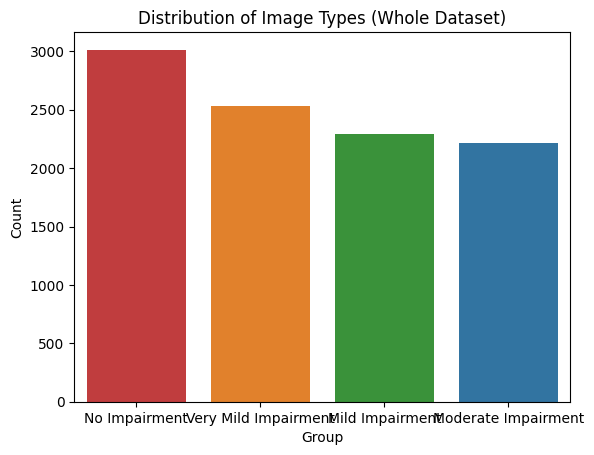

In [9]:
import seaborn as sns

# Plot distribution of images in the whole dataset
sns.countplot(data=df, x='Impairment_Type',
              order=['No Impairment', 'Very Mild Impairment', 'Mild Impairment', 'Moderate Impairment'],
              hue = "Impairment_Type")
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Distribution of Image Types (Whole Dataset)')
plt.show()

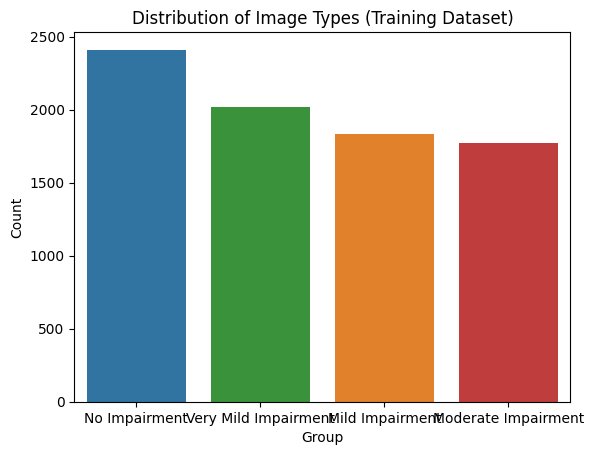

In [10]:
# Plot distribution of images in the training dataset
sns.countplot(data=train, x='Impairment_Type',
              order=['No Impairment', 'Very Mild Impairment', 'Mild Impairment', 'Moderate Impairment'],
              hue = "Impairment_Type")
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Distribution of Image Types (Training Dataset)')
plt.show()

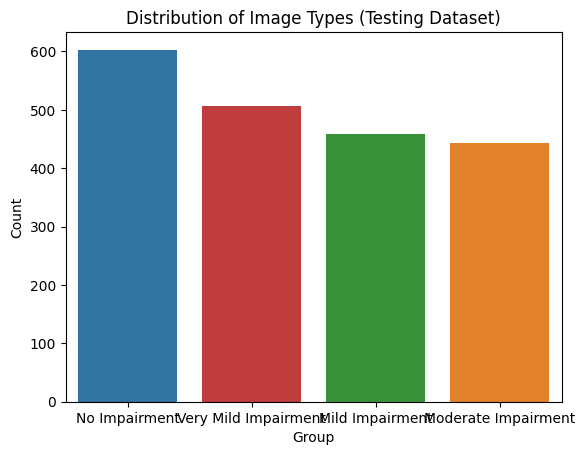

In [11]:
# Plot distribution of images in the testing dataset
sns.countplot(data=test, x='Impairment_Type',
              order=['No Impairment', 'Very Mild Impairment', 'Mild Impairment', 'Moderate Impairment'],
              hue = "Impairment_Type")
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Distribution of Image Types (Testing Dataset)')
plt.show()

In [ ]:
import shutil

# Assuming df is your DataFrame and has a column 'Impairment_Type' and 'Image_Path'
train, test = train_test_split(df, train_size=0.8, stratify=df['Impairment_Type'])

# Create directories for training and testing images
base_dir = '/content/drive/MyDrive/alzheimer detection'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Create directories if they don't exist
for directory in [train_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Move images into respective directories (class-based folders)
for label in train['Impairment_Type'].unique():
    label_train_dir = os.path.join(train_dir, label)
    if not os.path.exists(label_train_dir):
        os.makedirs(label_train_dir)

for label in test['Impairment_Type'].unique():
    label_test_dir = os.path.join(test_dir, label)
    if not os.path.exists(label_test_dir):
        os.makedirs(label_test_dir)

# Move images for the training set
for i, row in train.iterrows():
    shutil.copy(row['Image_Path'], os.path.join(train_dir, row['Impairment_Type'], row['Image_Name']))

# Move images for the test set
for i, row in test.iterrows():
    shutil.copy(row['Image_Path'], os.path.join(test_dir, row['Impairment_Type'], row['Image_Name']))


In [33]:
# Transform each image into a normalized tensor

data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}


In [32]:
from torch.utils.data import DataLoader

image_datasets = {
    'Training': datasets.ImageFolder(os.path.join(base_dir, 'Training'), data_transforms['Training']),
    'Testing': datasets.ImageFolder(os.path.join(base_dir, 'Testing'), data_transforms['Testing']),
}

dataloaders = {
    'Training': DataLoader(image_datasets['Training'], batch_size=32, shuffle=True),
    'Testing': DataLoader(image_datasets['Testing'], batch_size=32, shuffle=False),
}

dataset_sizes = {
    'Training': len(image_datasets['Training']),
    'Testing': len(image_datasets['Testing']),
}

class_names = image_datasets['Training'].classes


In [37]:
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")


Dataset sizes: {'Training': 8042, 'Testing': 2011}
Class names: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


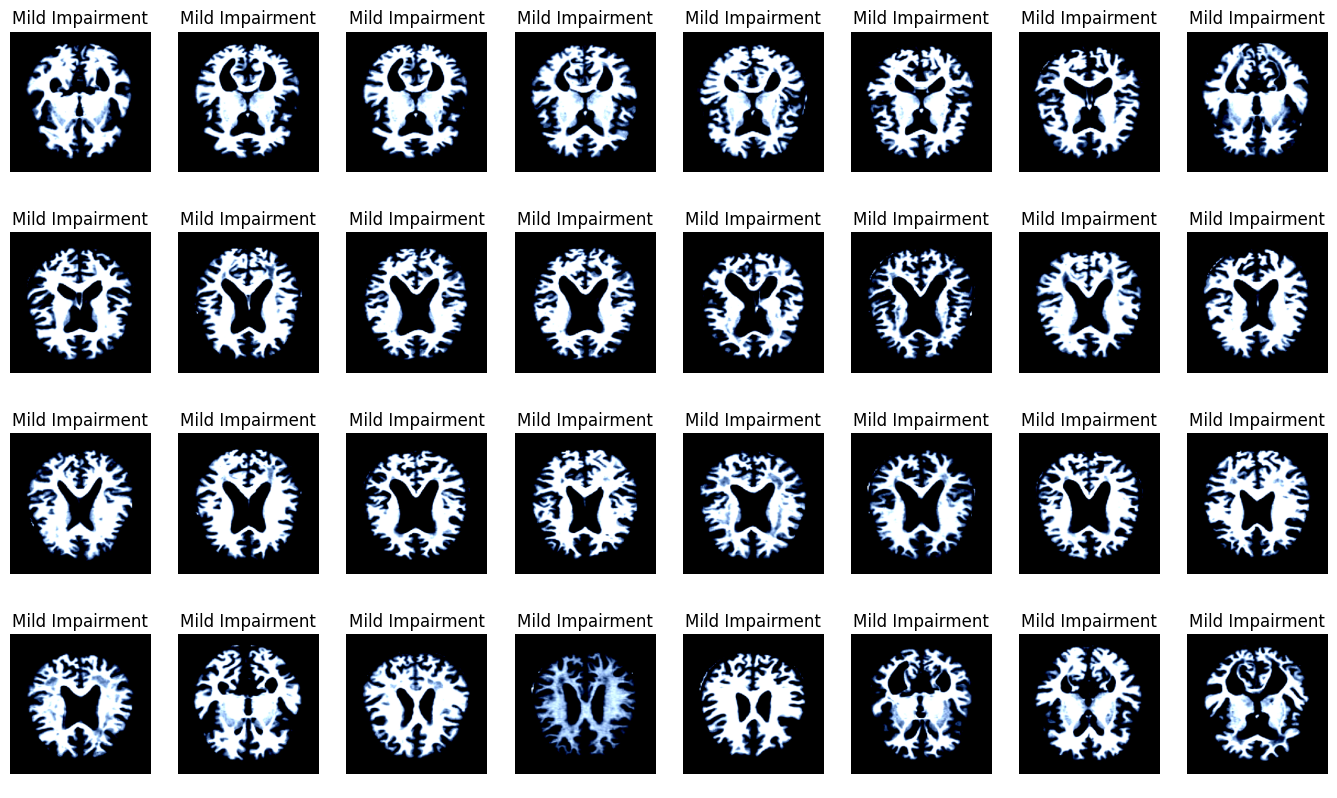

In [38]:
samples, labels = next(iter(dataloaders['Testing']))
plt.figure(figsize=(17, 10))
plt.axis('off')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(samples[i].permute(1, 2, 0))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8042 entries, 2335 to 4703
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Impairment_Type  8042 non-null   object
 1   Image_Name       8042 non-null   object
 2   Image_Path       8042 non-null   object
 3   Image_Data       8042 non-null   object
dtypes: object(4)
memory usage: 314.1+ KB


In [40]:
from torchvision.models import ResNet50_Weights

# Load the model with pre-trained weights
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all the layers
for param in model.parameters():
        param.requires_grad = False
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
import torch.nn as nn
from torchvision import models

# Load the pre-trained ResNet50 model
model = models.resnet50(weights='IMAGENET1K_V1')

# Get the number of input features to the original fully connected layer
in_features = model.fc.in_features

# Modify the fully connected layer (fc)
model.fc = nn.Sequential(
    nn.Linear(in_features, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4),
    nn.LogSigmoid()
)
# Move the model to the appropriate device (e.g., 'cuda' or 'cpu')
model = model.to(device)


In [43]:
for name, child in model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
#Optimizers
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [46]:
EPOCH = 30

In [47]:
# you can have other things like learning rate scheduler and ...
from torch.optim import lr_scheduler

# def step_scheduler(epoch):
#     if epoch < EPOCH * 0.5:
#         factor = 1
#     elif EPOCH * 0.5 <= epoch < EPOCH * 0.8:
#         factor = 0.1
#     else:
#         factor = 0.01
#     return factor

# scheduler = lr_scheduler.LambdaLR(optimizer, step_scheduler)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
### START CODE HERE

losses = []

# for training part you have to set model to train mode
model.train()

# loop on epochs
for e in tqdm(range(EPOCH)):
# loop on batches
  for inputs, labels in dataloaders['Training']:
    # print("*", end=" ")

    inputs = inputs.to(device)
    labels = labels.to(device)

    # set the grad to zero
    optimizer.zero_grad()

    # forward part
    # hint: using of pytorch max method (https://pytorch.org/docs/stable/generated/torch.max.html)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    #  compute loss
    loss = criterion(outputs, labels)


    # backward part
    loss.backward()

    # update parameters
    optimizer.step()

exp_lr_scheduler.step()
  # you have to append loss for each epoch
losses.append(loss)
### END CODE HERE

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
print(losses)

[tensor([0.5000, 1.2000, 0.8000]), tensor([0.5000, 1.2000, 0.8000])]


In [ ]:
losses = list(map(lambda x: x.cpu().detach().numpy(), losses))

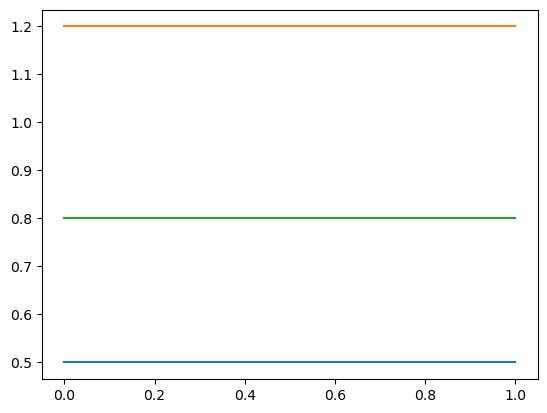

In [ ]:
plt.plot(list(range(len(losses))), losses)
plt.show()

In [ ]:
import torch

# Example tensor (simulating a loss value)
loss_tensor = torch.tensor([0.5, 1.2, 0.8], device='cpu')  # or device='cuda' if using a GPU

# List of tensors
losses = [loss_tensor, loss_tensor]

# Checking device before conversion to numpy
for loss_tensor in losses:
    print(f"Device before conversion: {loss_tensor.device}")

    # Now convert to NumPy
    numpy_loss = loss_tensor.cpu().detach().numpy()  # move to CPU, detach from graph, convert to NumPy
    print(f"Converted NumPy array: {numpy_loss}")
    print("-" * 50)


Device before conversion: cpu
Converted NumPy array: [0.5 1.2 0.8]
--------------------------------------------------
Device before conversion: cpu
Converted NumPy array: [0.5 1.2 0.8]
--------------------------------------------------


In [ ]:
# Assuming the tensor is on some device, we can track the device before conversion
device_info = [loss_tensor.device for loss_tensor in losses]  # Storing device info

# Convert to NumPy arrays
numpy_losses = [loss_tensor.cpu().detach().numpy() for loss_tensor in losses]

# Now you can use `device_info` to check where the original tensor was
for i, numpy_loss in enumerate(numpy_losses):
    print(f"Loss {i}: NumPy array: {numpy_loss}")
    print(f"Device before conversion: {device_info[i]}")


Loss 0: NumPy array: [0.5 1.2 0.8]
Device before conversion: cpu
Loss 1: NumPy array: [0.5 1.2 0.8]
Device before conversion: cpu


In [ ]:
losses = list(map(lambda x: x.cpu().detach().numpy(), losses))

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
# Check if tensor is on CPU
for loss_tensor in losses:
    print(loss_tensor.device)  # This will print 'cpu' if it's on the CPU


AttributeError: 'numpy.ndarray' object has no attribute 'device'

In [ ]:
print(losses)


[tensor([0.5000, 1.2000, 0.8000]), tensor([0.5000, 1.2000, 0.8000])]


/opt/homebrew/Caskroom/miniconda/base/envs/ds4003/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

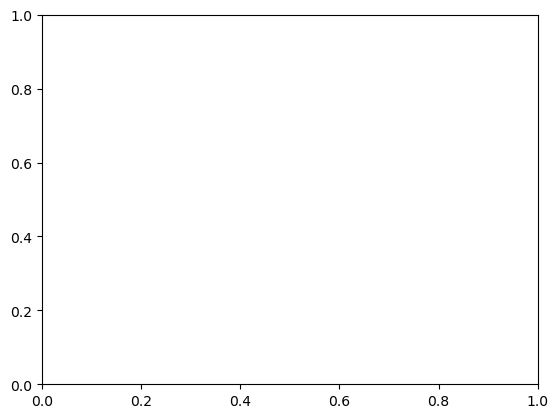

In [ ]:
plt.plot(list(range(len(losses))), losses)
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

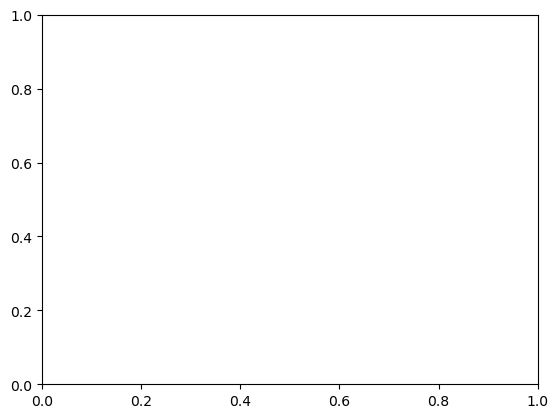

In [ ]:
# After the training loop is done, plot the losses
plt.plot(list(range(len(losses))), losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.show()


In [ ]:
img = df['Image_Data'][0]  # Access image data (PIL Image)
img.show()

AttributeError: 'numpy.ndarray' object has no attribute 'show'

In [ ]:
train, test = train_test_split(df,test_size=0.8,stratify=df['Impairment_Type'])

NameError: name 'df' is not defined

In [ ]:
print(train)

           Impairment_Type                                         Image_Name  \
2622  Very Mild Impairment  VeryMildImpairment-118-_jpg.rf.55e10430534418a...   
166    Moderate Impairment  ModerateImpairment-1206-_jpg.rf.e7773858f5509c...   
6988         No Impairment  NoImpairment-791-_jpg.rf.e0439b33568ccd046c790...   
7140         No Impairment  NoImpairment-1024-_jpg.rf.99fb6886424e09711f9a...   
1332   Moderate Impairment  ModerateImpairment-1540-_jpg.rf.988a0e7321c60d...   
...                    ...                                                ...   
9583         No Impairment  16-54-_jpg.rf.3d3f419495c9df10d92f4b58c0e9cf59...   
2584  Very Mild Impairment  VeryMildImpairment-1284-_jpg.rf.07ad1bc2959b91...   
1353   Moderate Impairment  ModerateImpairment-2305-_jpg.rf.53ab084d6a4529...   
5731       Mild Impairment  MildImpairment-1058-_jpg.rf.d1fefcc31f0f6c197a...   
4109  Very Mild Impairment  VeryMildImpairment-2526-_jpg.rf.52de600b1b0fa7...   

                           

In [ ]:
import plotly.express as px

fig = px.bar(train, x = 'Impairment_Type')
fig.show()

fig = px.bar(test, x = 'Impairment_Type')
fig.show()

In [ ]:
import os
import pandas as pd
from PIL import Image
import io
from google.colab import drive

# Mount Google Drive to access the files
drive.mount('/content/drive')

def create_image_dataframe(base_dir):
    # List to hold the rows of the dataframe
    data = []

    # Loop over the 'train' and 'test' directories
    for split in ['train', 'test']:
        split_dir = os.path.join(base_dir, split)

        # Check if the split directory exists
        if not os.path.isdir(split_dir):
            print(f"Directory not found: {split_dir}")
            continue

        # Iterate over each impairment type directory within train/test
        for impairment_type in ['Moderate Impairment', 'Very Mild Impairment', 'Mild Impairment']:
            impairment_dir = os.path.join(split_dir, impairment_type)

            for img_name in os.listdir(impairment_dir):
                if img_name.lower().endswith('.jpg'):
                    # Full image path
                    img_path = os.path.join(impairment_dir, img_name)

                    # Open the image and load it into memory as an object
                    with open(img_path, 'rb') as img_file:
                        img_data = img_file.read()  # Read the image file as bytes
                        img = Image.open(io.BytesIO(img_data))  # Open the image using Pillow

                    # Append a new row with impairment type, image name, image path, and image data
                    data.append([impairment_type, img_name, img_path, img])

    # Convert the list of data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['Impairment_Type', 'Image_Name', 'Image_Path', 'Image_Data'])
    return df

# Define your base directory where 'train' and 'test' folders are located in Google Drive
base_dir = '/content/drive/MyDrive/alzheimer_detection'  # Update path to reflect your Drive structure

# Generate the dataframe
df = create_image_dataframe(base_dir)

# Display the first few rows
print(df.head())
df.info()


In [ ]:
sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify= y=y)

In [ ]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 18.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 26.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 25.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
#CBAM module